In [129]:
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import os
import random
import gc
import tensorflow as tf


In [130]:
images_score = pd.read_csv('/Users/prakharsrivastav/Summer2023/place-pulse-2.0/images_score.csv')
images_score.head()

,Unnamed: 0,image_id,image_name,trueskill.score,trueskill.stds.-1
0,0,513d5905fdc9f03587003354,41.280511_1.999587_513d5905fdc9f03587003354_Ba...,19.715971,2.631917
1,1,513d7d45fdc9f03587007171,-33.437112_-70.630037_513d7d45fdc9f03587007171...,29.418738,2.162651
2,2,51409814fdc9f04926000c2d,41.862092_12.376161_51409814fdc9f04926000c2d_R...,23.745422,5.665297
3,3,50f448b1fdc9f065f00041e1,-33.898068_151.148908_50f448b1fdc9f065f00041e1...,26.008778,3.306227
4,4,513e6d16fdc9f0358700c24a,35.710636_139.614884_513e6d16fdc9f0358700c24a_...,28.214338,2.675751


In [131]:
train_dir = '/Users/prakharsrivastav/Summer2023/place-pulse-2.0/images'

all_images = ['/Users/prakharsrivastav/Summer2023/place-pulse-2.0/images/{}'.format(i) for i in os.listdir(train_dir)]

In [132]:
random.shuffle(all_images)

In [133]:
len(all_images)

110988

In [134]:
train_images = all_images[:4000]
test_images = all_images[-2000:]

print(len(train_images))
print(len(test_images))

4000
2000


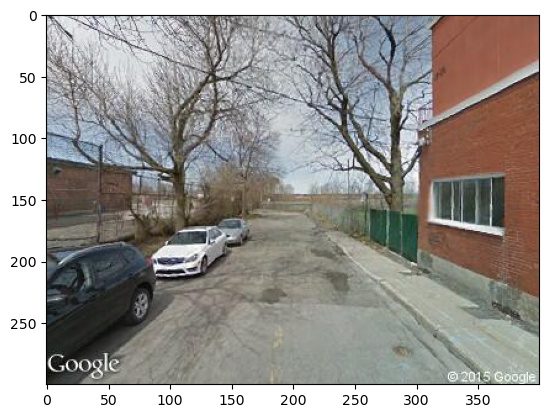

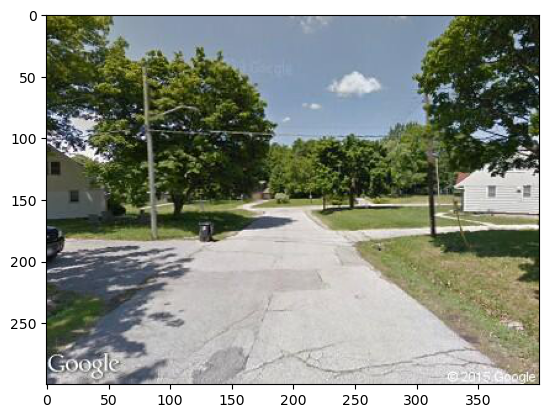

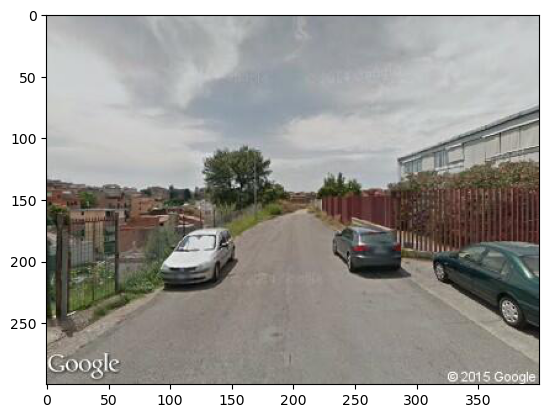

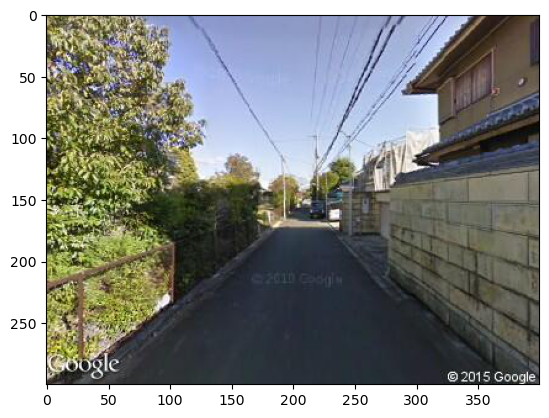

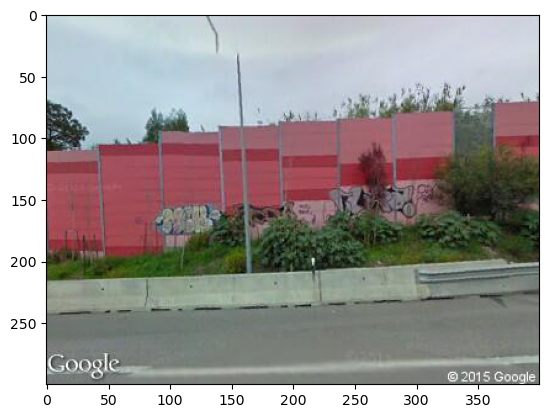

In [25]:
import matplotlib.image as mping

for ima in train_images[0:5]:
    img = mping.imread(ima)
    imgplot = plt.imshow(img)
    plt.show()

In [135]:
nrows = 150
ncolumns = 150
channels = 3

In [136]:
def read_and_process_image(list_of_images):
    X = []
    y = []

    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows, ncolumns), interpolation = cv2.INTER_CUBIC))
        
        image_id = image.split('_')[2]
        y.append(float(images_score.loc[images_score['image_id'] == image_id]['trueskill.score']))
    
    return np.array(X), np.array(y)

In [140]:
X, y = read_and_process_image(train_images)

In [142]:
max_train_y = np.max(y)

In [143]:
max_train_y

41.7999768238

In [144]:
y /= np.max(y, axis=0)
print(X.shape)
print(y.shape)

(4000, 150, 150, 3)
(4000,)


In [123]:
X[1]

array([[[ 19, 115, 110],
        [ 45, 140, 134],
        [ 33, 126, 121],
        ...,
        [ 20,  30,  27],
        [ 21,  27,  23],
        [ 19,  25,  20]],

       [[ 16,  97,  93],
        [ 47, 127, 124],
        [  4,  80,  78],
        ...,
        [ 17,  30,  26],
        [ 36,  45,  43],
        [ 18,  26,  20]],

       [[ 12,  73,  71],
        [ 27,  93,  90],
        [ 41, 103, 102],
        ...,
        [ 13,  28,  24],
        [ 42,  56,  52],
        [ 19,  32,  29]],

       ...,

       [[114, 100,  98],
        [126, 113, 113],
        [126, 117, 119],
        ...,
        [200, 218, 223],
        [174, 192, 194],
        [113, 135, 141]],

       [[100,  86,  84],
        [ 95,  80,  81],
        [ 88,  78,  80],
        ...,
        [196, 218, 223],
        [198, 222, 227],
        [122, 144, 150]],

       [[103,  87,  82],
        [104,  91,  88],
        [101,  89,  88],
        ...,
        [124, 155, 159],
        [130, 157, 163],
        [129, 151, 158]]

In [145]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

In [146]:
ntrain = len(X_train)
nval = len(X_val)
batch_size = 32

In [147]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

In [148]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


In [149]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_410 (Conv2D)         (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_411 (Conv2D)         (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_412 (Conv2D)         (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 17, 17, 128)     

In [150]:
model.compile(optimizer='sgd', loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])

In [151]:
#model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=['acc'])

In [152]:
# #model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

In [153]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,)

val_datagen = ImageDataGenerator(rescale=1./255)

In [154]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [155]:
history = model.fit(train_generator,
                              steps_per_epoch=ntrain // batch_size,
                              epochs= 20,
                              validation_data=val_generator,
                              validation_steps=nval // batch_size)

Epoch 1/20
100/100 [==============================] - 28s 275ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0105 - val_mean_squared_error: 0.0105
Epoch 2/20
100/100 [==============================] - 28s 284ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0105 - val_mean_squared_error: 0.0105
Epoch 3/20
100/100 [==============================] - 28s 281ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0105 - val_mean_squared_error: 0.0105
Epoch 4/20
100/100 [==============================] - 28s 274ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 5/20
100/100 [==============================] - 27s 272ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0105 - val_mean_squared_error: 0.0105
Epoch 6/20
100/100 [==============================] - 27s 269ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 7/20

---------------------------------------------------------------------------------------------------

In [96]:
from keras.applications import InceptionResNetV2

conv_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))

In [97]:
conv_base.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_207 (Conv2D)            (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_203 (Batch  (None, 74, 74, 32)  96          ['conv2d_207[0][0]']             
 Normalization)                                                                                   
                                                                                

In [98]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [99]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 3, 3, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten_2 (Flatten)         (None, 13824)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               3539200   
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 57,876,193
Trainable params: 57,815,649
Non-trainable params: 60,544
_________________________________________________________________


In [100]:
print('Number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('Number of trainable weights after freezing the conv base:', len(model.trainable_weights))

Number of trainable weights before freezing the conv base: 492
Number of trainable weights after freezing the conv base: 4


In [112]:
from keras import optimizers

model.compile(optimizer='sgd', loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
#model.compile(loss='mean', optimizer=optimizers.RMSprop(learning_rate=2e-5), metrics=['acc'])

In [113]:
train_datagen = ImageDataGenerator(rescale=1./255,   #Scale the image between 0 and 1
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

In [114]:
train_generator = train_datagen.flow(X_train, y_train,batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [115]:
history = model.fit(train_generator,
                              steps_per_epoch=ntrain // batch_size,
                              epochs=20,
                              validation_data=val_generator,
                              validation_steps=nval // batch_size)

Epoch 1/20
100/100 [==============================] - 79s 760ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 2/20
100/100 [==============================] - 82s 817ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 3/20
100/100 [==============================] - 92s 919ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 4/20
100/100 [==============================] - 90s 896ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 5/20
100/100 [==============================] - 93s 932ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 6/20
100/100 [==============================] - 91s 907ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 7/20

In [156]:
y_train[0]

0.6447326871185096

In [128]:
max(y)

1.0

In [157]:
#Save the model
model.save_weights('model_wieghts.h5')
model.save('model_keras.h5')

In [ ]:
#lets plot the train and val curve
import matplotlib.pyplot as plt

#get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()